In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler



In [79]:
test_churn = pd.read_csv("/Users/ahmadzarzar/Downloads/csv_hämtade_filer/churn_test.csv")
train_churn = pd.read_csv("/Users/ahmadzarzar/Downloads/csv_hämtade_filer/churn_train.csv")

# Analysera datan

In [80]:
train_churn.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1768-ZAIFU,Female,1,No,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,25.20,25.2,Yes
1,2159-TURXX,Male,0,No,No,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),20.05,95.55,No
2,8261-GWDBQ,Female,1,Yes,No,60,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.05,6925.9,No
3,2732-ISEZX,Female,0,No,No,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.50,104.3,No
4,7607-QKKTJ,Male,0,Yes,Yes,45,Yes,Yes,Fiber optic,No,...,Yes,No,No,Yes,One year,Yes,Credit card (automatic),95.00,4368.85,No


In [81]:
train_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 


### Finns dubbletter?

In [82]:
print(f'***Train_churn***\n{train_churn.duplicated().value_counts()}')

***Train_churn***
False    5634
dtype: int64


### Saknas värden?

In [83]:
print(f'***Train_churn***\n{train_churn.isna().sum()}')

***Train_churn***
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


### Hur ser fördelningen av target datan ut? Är den jämt fördelad? Om inte, kan det ställa till med problem?

Customers who stayed:   4148
Customers who churned:   1486


Text(0, 0.5, 'Count')

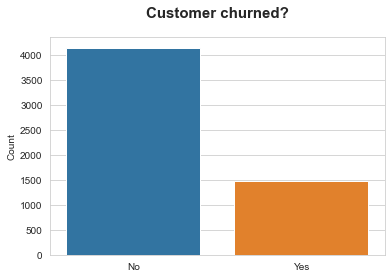

In [84]:
target_dist = train_churn['Churn'].value_counts()
print('Customers who stayed:  ', target_dist[0])
print('Customers who churned:  ', target_dist[1])


# Visualize the customer churn distribution
sns.set_style('whitegrid')
sns.barplot(x=target_dist.index, y=target_dist.values)
plt.title('Customer churned?', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Count')

Det är uppenbart att det inte jämt fördelad det är klassobalans i vår datauppsättning eftersom det är typ 26,5 % av kunderna churnade medan 73,5 % av kunderna stannade.
om det kan ställa till med problem,ja eftersom Eftersom beslutsträdsbaserade modeller som XGBoost är mottagliga för frekvens datapunkter, därför måste vi göra med klassobalansen på ett av två sätt för att göra fördelningen mer lika

##  Förbered datan för att kunna användas av modellen

## Finns det data som ej borde användas? Varför i så fall?

In [85]:

train_churn['TotalCharges'] = train_churn.TotalCharges.replace({' ': 0})
train_churn['TotalCharges'] = pd.to_numeric(train_churn.TotalCharges, errors='coerce')


# remove the 9 rows with missing values
# print(train_churn.info())


train_churn = train_churn.drop('customerID', axis=1)

train_churn['Churn'] = train_churn.Churn.replace({'No': 0, 'Yes':1})





test_churn['TotalCharges'] = test_churn.TotalCharges.replace({' ': 0})
test_churn['TotalCharges'] = pd.to_numeric(test_churn.TotalCharges, errors='coerce')


# remove the 9 rows with missing values
# print(test_churn.info())


test_churn = test_churn.drop('customerID', axis=1)

test_churn['Churn'] = test_churn.Churn.replace({'No': 0, 'Yes':1})




x_train=train_churn.drop(columns=['Churn'])
y_train=train_churn.Churn

x_test =test_churn.drop(columns=['Churn'])
y_test= test_churn.Churn




In [86]:
train_churn.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1499
TotalCharges        5290
Churn                  2
dtype: int64

In [87]:
# generate the list of categorical and numerical variables
categorical_variables = train_churn.nunique()[train_churn.nunique() < 5].keys().to_list()

numerical_variables=list(set(train_churn.columns) - set(categorical_variables))
categorical_variables.remove('Churn')

ohe = OneHotEncoder(drop='first', sparse=False)

X_train_ohe = ohe.fit_transform(x_train[categorical_variables])
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(categorical_variables))

# Transform only without fitting
X_test_ohe = ohe.transform(x_test[categorical_variables])
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(categorical_variables))


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(x_train[numerical_variables])
X_train_sc_df = pd.DataFrame(X_train_sc, columns=numerical_variables)

# Transform only without fitting
X_test_sc = scaler.transform(x_test[numerical_variables])
X_test_sc_df = pd.DataFrame(X_test_sc, columns=numerical_variables)

# Merging the transformed dataframe togheter
x_train = pd.merge(X_train_ohe_df, X_train_sc_df, left_index=True, right_index=True)
x_test = pd.merge(X_test_ohe_df, X_test_sc_df, left_index=True, right_index=True)

In [88]:

# fit model no training data
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [89]:

test=model.score(x_test,y_test)


test

0.7821149751596878

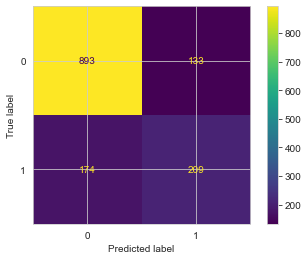

In [90]:
plot_confusion_matrix(model, x_test, y_test)  
plt.show()